In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange

from jaxtyping import Float
from torch import Tensor

In [2]:
import matplotlib.pyplot as plt

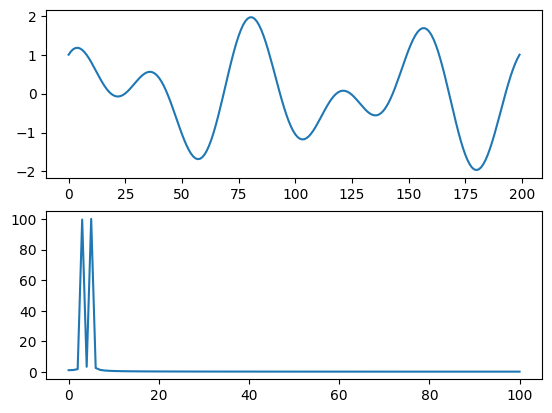

In [3]:
_, (ax1, ax2) = plt.subplots(2, 1)
x = np.linspace(0., 2 * np.pi, 200)
y1 = x * 3
y2 = 5 * x
z = np.sin(y1) + np.cos(y2)
ax1.plot(z)
ax2.plot(np.abs(np.fft.rfft(z)))

In [4]:
def deteck_topk_periods(
        x:Float[Tensor, "B L C"],
        k:int=3,
        min_period:int=2, 
        max_period:int=64
) -> list[int]:
    B, L, C = x.shape
    fft_vals = torch.fft.rfft(x, dim=1)
    print(fft_vals.shape)
    amplitudes = fft_vals.abs().mean(dim=2)
    print(amplitudes.shape)

    freqs = torch.fft.rfftfreq(L)
    valid = (freqs > 0) & (freqs * L >= min_period) & (freqs * L <= max_period)
    amplitudes = amplitudes[:, valid]
    freqs = freqs[valid]

    mean_amplitude = amplitudes.mean(dim=0)
    topk_freq = freqs[mean_amplitude.topk(k).indices]
    print(topk_freq)
    topk_periods = (L / topk_freq).round().int().tolist()

    return sorted(set(topk_periods))

In [5]:
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]



In [6]:
FFT_for_Period(torch.from_numpy(z).reshape(1, -1, 1))

(array([40, 66]), tensor([[100.1521,  99.7238]], dtype=torch.float64))

# Model defintion

we use routines from `https://github.com/thuml/Time-Series-Library/` and put everything needed for the model in one cell. This is slightly simplified since we are only interested in classification and anomaly detection.

In [48]:
from dataclasses import dataclass

@dataclass
class ConfigTimesNet:
    seq_len: int          # length of history fed to the model
    pred_len: int         # number of steps to predict (used by TimesBlock & head)
    top_k: int            # how many dominant periods to keep from FFT
    d_ff: int             # hidden width inside Inception block
    d_model: int          # embedding / channel width of the main stream
    num_kernels: int      # #convolution branches in Inception
    task_name: str        # 'anomaly_detection' | 'classification'
    label_len: int        # (only relevant for other TimesNet variants)
    enc_in: int           # #input variables
    embed: str            # 'fixed' | 'learnable' | 'timeF'
    freq: str             # one-letter alias: 'h','t','s','m','a','w','d','b'
    dropout: float
    e_layers: int         # how many TimesBlocks to stack
    c_out: int            # #output variables or features
    num_class: int        # for classification head

class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i)
            )
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.requires_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        ).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type="timeF", freq="h"):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {"h": 4, "t": 5, "s": 6, "m": 1, "a": 1, "w": 2, "d": 3, "b": 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type="fixed", freq="h"):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == "fixed" else nn.Embedding
        if freq == "t":
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = (
            self.minute_embed(x[:, :, 4]) if hasattr(self, "minute_embed") else 0.0
        )
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.requires_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        ).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return self.pe[:, : x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= "1.5.0" else 2
        self.tokenConv = nn.Conv1d(
            in_channels=c_in,
            out_channels=d_model,
            kernel_size=3,
            padding=padding,
            padding_mode="circular",
            bias=False,
        )
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_in", nonlinearity="leaky_relu"
                )

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type="fixed", freq="h", dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = (
            TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)
            if embed_type != "timeF"
            else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)
        )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = (
                self.value_embedding(x)
                + self.temporal_embedding(x_mark)
                + self.position_embedding(x)
            )
        return self.dropout(x)


def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(
                configs.d_model, configs.d_ff, num_kernels=configs.num_kernels
            ),
            nn.GELU(),
            Inception_Block_V1(
                configs.d_ff, configs.d_model, num_kernels=configs.num_kernels
            ),
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros(
                    [x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]
                ).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = self.seq_len + self.pred_len
                out = x
            # reshape
            out = (
                out.reshape(B, length // period, period, N)
                .permute(0, 3, 1, 2)
                .contiguous()
            )
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, : (self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


class TimesNetModel(nn.Module):
    """
    Paper link: https://openreview.net/pdf?id=ju_Uqw384Oq
    """

    def __init__(self, configs):
        super(TimesNetModel, self).__init__()
        self.configs = configs
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.model = nn.ModuleList(
            [TimesBlock(configs) for _ in range(configs.e_layers)]
        )
        self.enc_embedding = DataEmbedding(
            configs.enc_in,
            configs.d_model,
            configs.embed,
            configs.freq,
            configs.dropout,
        )
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)
        if self.task_name == "imputation" or self.task_name == "anomaly_detection":
            self.projection = nn.Linear(configs.d_model, configs.c_out, bias=True)
        if self.task_name == "classification":
            self.act = F.gelu
            self.dropout = nn.Dropout(configs.dropout)
            self.projection = nn.Linear(
                configs.d_model * configs.seq_len, configs.num_class
            )

    def anomaly_detection(self, x_enc):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc.sub(means)
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc = x_enc.div(stdev)

        # embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B,T,C]
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        # project back
        dec_out = self.projection(enc_out)

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out.mul(
            (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len + self.seq_len, 1))
        )
        dec_out = dec_out.add(
            (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len + self.seq_len, 1))
        )
        return dec_out

    def classification(self, x_enc, x_mark_enc):
        # embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B,T,C]
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Output
        # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.act(enc_out)
        output = self.dropout(output)
        # zero-out padding embeddings
        output = output * x_mark_enc.unsqueeze(-1)
        # (batch_size, seq_length * d_model)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)
        return output

    def forward(self, x_enc, x_mark_enc):
        if self.task_name == "anomaly_detection":
            dec_out = self.anomaly_detection(x_enc)
            return dec_out  # [B, L, D]
        if self.task_name == "classification":
            dec_out = self.classification(x_enc, x_mark_enc)
            return dec_out  # [B, N]
        return None

## YAML File 
We'll use something similar to this later when we refactor routines into separate files and make a driver for training

```yaml
model: timesnet

net_params: 
# Use the above config to define the parameters of `TimesNet`
model_params:
  lookback: 40
  batch_size: 256
  epochs: 20
  patience: 4          # early-stop after 4 worse AUC
  lr: 3.0e-4

class_weight: balanced
top_k: 0.02
feature_cols: [log_ret, z_log_ret, vol_scaled]

data:
  train: data/splits/train_scaled_matrix.parquet
  val:   data/splits/val_scaled_matrix.parquet
  test:  data/splits/test_scaled_matrix.parquet

  train_df: data/splits/train_scaled_matrix.parquet
  val_df:   data/splits/val_scaled_matrix.parquet
  test_df:  data/splits/test_scaled_matrix.parquet

artifact_dir: artifacts/exp_timesnet

```

In [11]:
@dataclass
class ConfigTraining:
    net: ConfigTimesNet
    lookback: int
    batch_size: int
    epochs: int
    patience: int
    lr: float
    

# Training routines

In [ ]:
from sklearn.metrics import roc_auc_score
from einops import rearrange
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def model_forward(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    if isinstance(model, TimesNetModel):
        x = rearrange(x, 'B L T F -> B L (T F)')
        ones = torch.ones(x.shape[:-1], dtype=x.dtype, device=x.device)
        return model(x, ones)
    if isinstance(model, TimeSeriesTransformer):
        x = rearrange(x, 'B L T F -> B L (T F)')
        return model(x)
    if isinstance(model, TimeSeriesTransformerEnhanced):
        return model(x)


def eval(model: nn.Module, loss_fn, dl_val: DataLoader, device: torch.device):
    model.eval()

    running_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dl_val:
            x = batch['features'].to(device, non_blocking=True)
            y = batch['target'].to(device, non_blocking=True).float()
            logits = model_forward(model, x)
            loss = loss_fn(logits.squeeze(), y)

            bs = y.size(0)
            running_loss += loss.item() * bs

            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            y_pred.append(probs)
            y_true.append(y.cpu().numpy())
    
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    ave_loss =  running_loss / len(dl_val.dataset) 
    auc = roc_auc_score(y_true, y_pred)

    model.train()

    return ave_loss, auc


def train(model: nn.Module, config: ConfigTraining, dl_train: DataLoader, dl_val:DataLoader):
    opt = torch.optim.AdamW(model.parameters(), config.lr)
    loss_fn = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    writer = SummaryWriter(log_dir='log_TimesNetTraining')

    best_auc = 0.0
    best_val_loss = np.inf
    best_state = None
    patience_left = config.patience

    i_step = 0
    
    for epoch in range(1, config.epochs + 1):
        model.train()
        epoch_loss = 0.0

        pbar = tqdm(dl_train, desc=f"Epoch {epoch}", leave=False)
        for batch in pbar:
            x = batch['features'].to(device, non_blocking=True)
            y = batch['target'].to(device, non_blocking=True).unsqueeze(-1)
            opt.zero_grad()
            loss = loss_fn(model_forward(model, x), y)
            pbar.set_postfix(loss=loss.item())
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            writer.add_scalar('loss/train/batch', loss.item(), i_step)
            i_step += 1
            gpu_mem_mb = torch.cuda.memory_allocated() / 1024**2
            writer.add_scalar('resources/gpu/memory_used_mb_batch', gpu_mem_mb, i_step)
        
        epoch_loss /= len(dl_train)
        writer.add_scalar('loss/train/epoch', epoch_loss, epoch)
        
        val_loss, val_auc = eval(model, loss_fn, dl_val, device)

        writer.add_scalar('loss/val', val_loss, epoch)
        writer.add_scalar('metrics/val/auc', val_auc, epoch)

        tqdm.write(f"epoch {epoch:03d} | Loss {epoch_loss:.4f} | Val AUC {val_auc:.4f} | Val Loss {val_loss:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = model.state_dict()
            torch.save({
                'model_state': model.state_dict(),
                'optimizer_state': opt.state_dict(),
                'epoch': epoch,
            }, "best_model.pt")
            torch.save(best_state, "best_model.pt")
            tqdm.write(f"  New best AUC: {best_auc:.4f} (model saved)")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        else:
            patience_left -= 1
            if patience_left == 0:
                tqdm.write("Early Stop!")        
                break
    
    if best_state is not None:
        model.load_state_dict(best_state)
    writer.close()
    return model, best_auc

# Config for the model
Should be small enough to run a couple of epochs and see metrics and overall convergence behavior.

In [92]:
config = ConfigTimesNet(
    seq_len=40,
    pred_len=0,
    top_k=12,
    d_ff=256,
    d_model=256,
    num_kernels=3,
    task_name='classification',
    label_len=0,
    enc_in=114,     # 19 tickers including the focal asset each with 6 features.
    embed='fixed',
    freq='h',
    dropout=0.1,
    e_layers=3,
    c_out=1,
    num_class=1
)
model = TimesNetModel(config)
config_train = ConfigTraining(
    net=config,
    lookback=40,
    batch_size=256,
    epochs=100,
    patience=10,
    lr=1e-4
)

In [93]:
from dataprep.window_dataset import WindowDataset
from torch.utils.data import DataLoader

dset_trian = WindowDataset('data/splits/train_scaled_matrix.parquet')
dset_val = WindowDataset('data/splits/val_scaled_matrix.parquet')

dl_train = DataLoader(dset_trian, batch_size=config_train.batch_size, shuffle=True, pin_memory=True)
dl_val = DataLoader(dset_val, batch_size=config_train.batch_size, pin_memory=True)

[Dataset] Entity axis order: ['<ASSET>', 'CL=F', 'DX=F', 'GC=F', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'ZB=F', 'ZN=F', 'ZT=F', '^VIX']
[Dataset] Entity axis order: ['<ASSET>', 'CL=F', 'DX=F', 'GC=F', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'ZB=F', 'ZN=F', 'ZT=F', '^VIX']


In [94]:
model = TimesNetModel(config)
model, best_auc = train(model, config_train, dl_train, dl_val)

epoch 001 | Loss 0.4780 | Val AUC 0.4842 | Val Loss 0.5713
  New best AUC: 0.4842 (model saved)


epoch 002 | Loss 0.4513 | Val AUC 0.4651 | Val Loss 0.5944


epoch 003 | Loss 0.4425 | Val AUC 0.4721 | Val Loss 0.6222


epoch 004 | Loss 0.4309 | Val AUC 0.5181 | Val Loss 0.5790
  New best AUC: 0.5181 (model saved)


epoch 005 | Loss 0.4173 | Val AUC 0.5179 | Val Loss 0.5877


epoch 006 | Loss 0.4015 | Val AUC 0.5322 | Val Loss 0.6011
  New best AUC: 0.5322 (model saved)


epoch 007 | Loss 0.3847 | Val AUC 0.5386 | Val Loss 0.5941
  New best AUC: 0.5386 (model saved)


epoch 008 | Loss 0.3661 | Val AUC 0.5154 | Val Loss 0.6227


epoch 009 | Loss 0.3430 | Val AUC 0.5132 | Val Loss 0.6653


epoch 010 | Loss 0.3199 | Val AUC 0.5101 | Val Loss 0.6741


epoch 011 | Loss 0.2897 | Val AUC 0.5198 | Val Loss 0.6733
Early Stop!


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attention_weights = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, L, d_model)
        weights = self.attention_weights(x)  # (B, L, 1)
        weights = F.softmax(weights, dim=1)  # (B, L, 1)
        pooled = torch.sum(weights * x, dim=1)  # (B, d_model)
        return pooled


class TimeSeriesTransformerEnhanced(nn.Module):
    def __init__(self, num_tickers, num_features, seq_len, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TimeSeriesTransformerEnhanced, self).__init__()

        self.T = num_tickers
        self.F = num_features
        self.L = seq_len
        self.d_model = d_model

        # 1D Convolution over ticker-feature dimension
        self.conv = nn.Conv1d(in_channels=self.F, out_channels=d_model, kernel_size=1)

        # LayerNorm before projection
        self.norm = nn.LayerNorm(num_features)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        nn.init.normal_(self.pos_embedding, std=0.02)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Attention pooling
        self.attn_pool = AttentionPooling(d_model)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        # x: (B, L, T, F)
        B, L, T, F = x.shape

        # Reshape for convolution: merge B and L
        x = x.view(B * L, T, F)
        x = self.norm(x)  # Apply LayerNorm over features
        x = x.permute(0, 2, 1)  # (B*L, F, T)
        x = self.conv(x)  # (B*L, d_model, T)
        x = x.mean(dim=2)  # Average over tickers → (B*L, d_model)
        x = x.view(B, L, self.d_model)  # Reshape back → (B, L, d_model)

        # Add positional encoding
        x = x + self.pos_embedding[:, :L, :]

        # Transformer encoder
        x = self.transformer(x)  # (B, L, d_model)

        # Attention pooling
        x = self.attn_pool(x)  # (B, d_model)

        # Classification head
        logits = self.classifier(x)  # (B, 1)

        return logits  # Use with BCEWithLogitsLoss externally



In [81]:
config_train = ConfigTraining(
    net=config,
    lookback=40,
    batch_size=256,
    epochs=10,
    patience=5,
    lr=2e-4
)
model = TimeSeriesTransformerEnhanced(19, 6, 40, d_model=512, nhead=64, num_layers=12, dim_feedforward=1024)
from dataprep.window_dataset import WindowDataset
from torch.utils.data import DataLoader

dset_trian = WindowDataset('data/splits/train_scaled_matrix.parquet')
dset_val = WindowDataset('data/splits/val_scaled_matrix.parquet')

dl_train = DataLoader(dset_trian, batch_size=config_train.batch_size, shuffle=True, pin_memory=True)
dl_val = DataLoader(dset_val, batch_size=config_train.batch_size, pin_memory=True)

model, best_auc = train(model, config_train, dl_train, dl_val)

[Dataset] Entity axis order: ['<ASSET>', 'CL=F', 'DX=F', 'GC=F', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'ZB=F', 'ZN=F', 'ZT=F', '^VIX']
[Dataset] Entity axis order: ['<ASSET>', 'CL=F', 'DX=F', 'GC=F', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'ZB=F', 'ZN=F', 'ZT=F', '^VIX']


epoch 001 | Loss 0.5490 | Val AUC 0.6232 | Val Loss 0.5398
  New best AUC: 0.6232 (model saved)


epoch 002 | Loss 0.5485 | Val AUC 0.5374 | Val Loss 0.5411


epoch 003 | Loss 0.5468 | Val AUC 0.5036 | Val Loss 0.5412


epoch 004 | Loss 0.5460 | Val AUC 0.4966 | Val Loss 0.5398


epoch 005 | Loss 0.5459 | Val AUC 0.5048 | Val Loss 0.5425


epoch 006 | Loss 0.5455 | Val AUC 0.5000 | Val Loss 0.5399


epoch 007 | Loss 0.5458 | Val AUC 0.5053 | Val Loss 0.5430
Early Stop!
